<xarray.Dataset> Size: 166kB
Dimensions:      (y: 400, x: 400)
Coordinates:
  * y            (y) float64 3kB -1.971e+06 -1.971e+06 ... -1.975e+06 -1.975e+06
  * x            (x) float64 3kB 1.393e+06 1.393e+06 ... 1.397e+06 1.397e+06
Data variables:
    spatial_ref  int64 8B ...
    def_year     (y, x) uint8 160kB ...


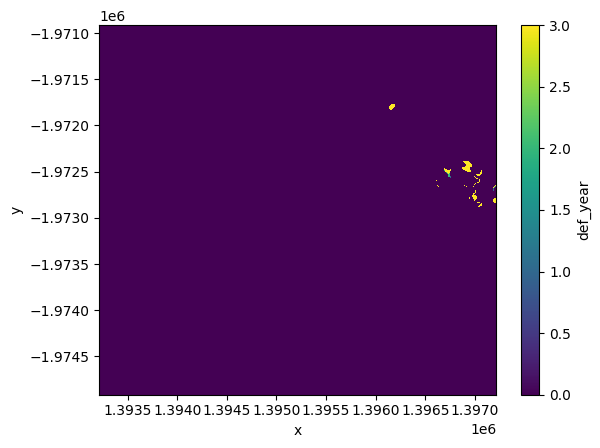

In [1]:
import xarray as xr

da = xr.open_dataset("defor_200_200.nc")
print(da)

da = da.def_year

da.where(da<255, 0).plot()

In [2]:
from geocube.vector import vectorize

gdf = vectorize(da)
gdf = gdf[gdf["def_year"] != 255]
gdf = gdf[gdf["def_year"] != 0]

gdf.head()

,def_year,geometry
1,3.0,"POLYGON ((1396154.806 -1971764.493, 1396194.80..."
4,3.0,"POLYGON ((1396884.806 -1972384.493, 1396944.80..."
5,3.0,"POLYGON ((1396684.806 -1972464.493, 1396684.80..."
6,2.0,"POLYGON ((1396684.806 -1972484.493, 1396684.80..."
7,2.0,"POLYGON ((1396704.806 -1972504.493, 1396704.80..."


<Axes: >

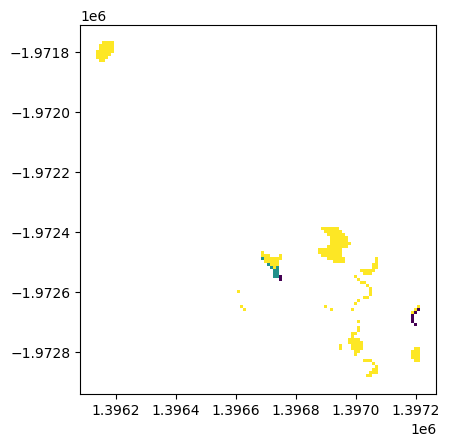

In [3]:
gdf.plot(column=gdf['def_year'])  # defor years 1,2,3

In [23]:
import requests
import json
import io
import xarray as xr

url = "https://terrakio-server-candidate-35868758936.europe-west4.run.app/wcs"

x0 = 593219.8059865793
y0 = -1170919.4925569955
dx = 10
dy = -10
tile_size = 400

payload_template = {
  "feature": None,
  "in_crs": "epsg:3577",
  "out_crs": "epsg:3577",
  "resolution": 10,
  "expr": None,
  "output": "netcdf"
}

def request_ancillary_layers(feat, expr):
    payload = payload_template.copy()
    payload["feature"] = feat
    payload["expr"] = expr

    print(json.dumps(payload))
    
    headers = {
    'Content-Type': 'application/json'
    }
    
    resp = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    # check if the request was successful
    if not resp.ok:
        print(resp.text)
    resp.raise_for_status()

    # read the response as a binary stream and load as an xarray dataset
    ds = xr.open_dataset(io.BytesIO(resp.content))
    ds.rio.write_crs("EPSG:3577", inplace=True)
    
    return ds.var0

def generate_feature(i, j, n):
    x0_tile = x0 + tile_size * i * dx
    y0_tile = y0 + tile_size * j * dy

    x1_tile = x0_tile + tile_size * n * dx
    y1_tile = y0_tile + tile_size * n * dy

    return {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates":
                [[[x0_tile, y0_tile],
                [x1_tile, y0_tile],
                [x1_tile, y1_tile],
                [x0_tile, y1_tile],
                [x0_tile, y0_tile]]]
        }
    }


feat = generate_feature(200, 200, 1)

allTree_expr = "Alltrees.alltrees"
allTree_expr = "WCF_v2_min.s2v2_min_wcf"
ds_trees = request_ancillary_layers(feat, allTree_expr)

ds_trees

{"feature": {"type": "Feature", "geometry": {"type": "Polygon", "coordinates": [[[1393219.8059865793, -1970919.4925569955], [1397219.8059865793, -1970919.4925569955], [1397219.8059865793, -1974919.4925569955], [1393219.8059865793, -1974919.4925569955], [1393219.8059865793, -1970919.4925569955]]]}}, "in_crs": "epsg:3577", "out_crs": "epsg:3577", "resolution": 10, "expr": "WCF_v2_min.s2v2_min_wcf", "output": "netcdf"}


<xarray.DataArray 'var0' (time: 7, y: 400, x: 400)> Size: 4MB
[1120000 values with dtype=float32]
Coordinates:
  * x            (x) float64 3kB 1.393e+06 1.393e+06 ... 1.397e+06 1.397e+06
  * y            (y) float64 3kB -1.971e+06 -1.971e+06 ... -1.975e+06 -1.975e+06
  * time         (time) datetime64[ns] 56B 2017-01-01 2018-01-01 ... 2023-01-01
    spatial_ref  int64 8B 0

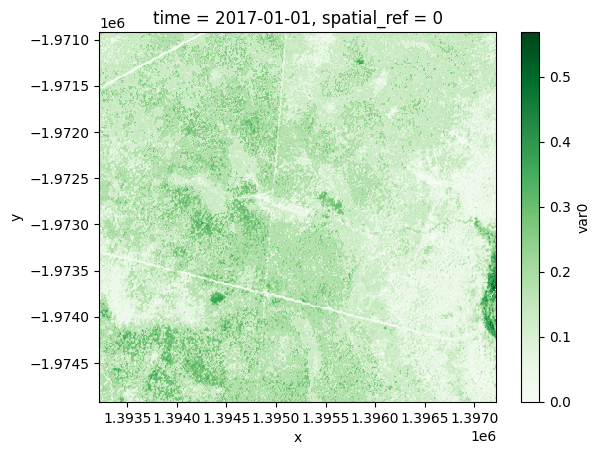

In [24]:
ds_trees.isel(time=0).plot(cmap="Greens")
#ds_trees.isel(time=0).plot.hist(bins=100)

In [5]:
ds_trees.time

<xarray.DataArray 'time' (time: 4)> Size: 32B
array(['2020-01-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 32B 2020-01-01 2021-01-01 ... 2023-01-01
    spatial_ref  int64 8B 0

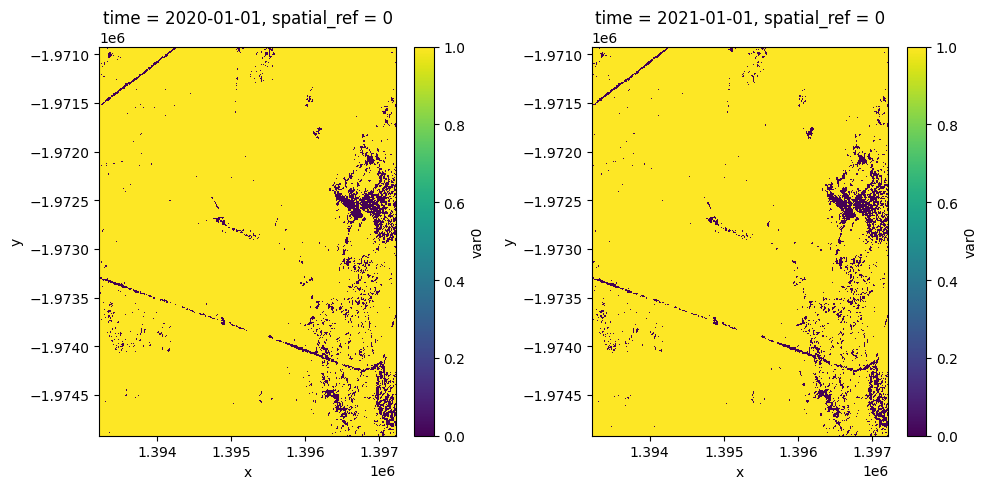

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ds_trees.isel(time=0).plot(ax=axes[0])
ds_trees.isel(time=1).plot(ax=axes[1])
plt.tight_layout()
plt.show()

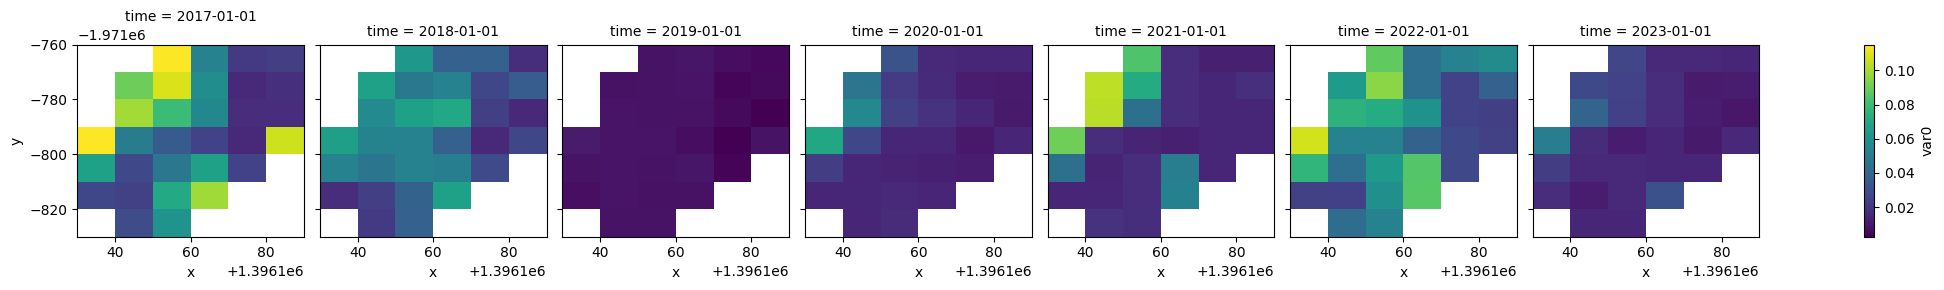

In [25]:
ds_trees.rio.clip([gdf.geometry.iloc[0]]).plot(col="time")

### Task 3. Verify alignment of deforestation tile

In [10]:
import requests
import json
import io
import xarray as xr

url = "https://terrakio-server-candidate-35868758936.europe-west4.run.app/wcs"

x0 = 593219.8059865793
y0 = -1170919.4925569955
dx = 10
dy = -10
tile_size = 400

payload_template = {
  "feature": None,
  "in_crs": "epsg:3577",
  "out_crs": "epsg:3577",
  "resolution": 10,
  "expr": None,
  "output": "netcdf"
}

def request_ancillary_layers(feat, expr):
    payload = payload_template.copy()
    payload["feature"] = feat
    payload["expr"] = expr

    print(json.dumps(payload))
    
    headers = {
    'Content-Type': 'application/json'
    }
    
    resp = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    # check if the request was successful
    if not resp.ok:
        print(resp.text)
    resp.raise_for_status()

    # read the response as a binary stream and load as an xarray dataset
    ds = xr.open_dataset(io.BytesIO(resp.content))
    ds.rio.write_crs("EPSG:3577", inplace=True)
    
    return ds.var0

def generate_feature(i, j, n):
    x0_tile = x0 + tile_size * i * dx
    y0_tile = y0 + tile_size * j * dy

    x1_tile = x0_tile + tile_size * n * dx
    y1_tile = y0_tile + tile_size * n * dy

    return {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates":
                [[[x0_tile, y0_tile],
                [x1_tile, y0_tile],
                [x1_tile, y1_tile],
                [x0_tile, y1_tile],
                [x0_tile, y0_tile]]]
        }
    }


feat = generate_feature(200, 200, 1)

def_expr = "Defqld.aus@(year=2023)"
ds_def = request_ancillary_layers(feat, def_expr)

ds_def

{"feature": {"type": "Feature", "geometry": {"type": "Polygon", "coordinates": [[[1393219.8059865793, -1970919.4925569955], [1397219.8059865793, -1970919.4925569955], [1397219.8059865793, -1974919.4925569955], [1393219.8059865793, -1974919.4925569955], [1393219.8059865793, -1970919.4925569955]]]}}, "in_crs": "epsg:3577", "out_crs": "epsg:3577", "resolution": 10, "expr": "Defqld.aus@(year=2023)", "output": "netcdf"}


<xarray.DataArray 'var0' (time: 1, y: 400, x: 400)> Size: 640kB
[160000 values with dtype=float32]
Coordinates:
  * x            (x) float64 3kB 1.393e+06 1.393e+06 ... 1.397e+06 1.397e+06
  * y            (y) float64 3kB -1.971e+06 -1.971e+06 ... -1.975e+06 -1.975e+06
  * time         (time) datetime64[ns] 8B 2023-01-01
    spatial_ref  int64 8B 0

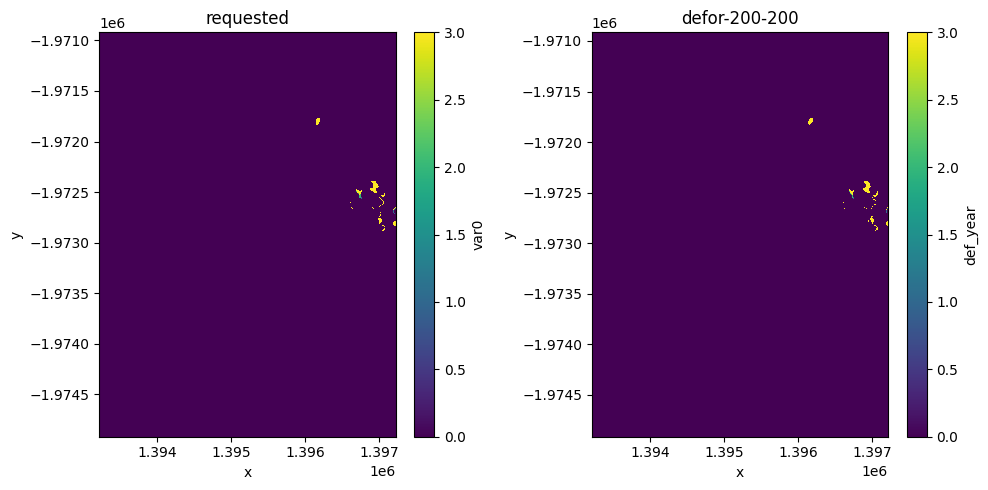

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# requested defor
da_def = ds_def.where(ds_def<255, 0).isel(time=0)
da_def.plot(ax=axes[0])
axes[0].set_title('requested')

da = xr.open_dataset("defor_200_200.nc") 
da = da.def_year
da.where(da<255, 0).plot(ax=axes[1])  #def tile from dataset
axes[1].set_title('defor-200-200')

plt.tight_layout()
plt.show()

### Task 4. Compare forest mapping with defor tile

In [12]:
import requests
import json
import io
import xarray as xr

url = "https://terrakio-server-candidate-35868758936.europe-west4.run.app/wcs"

x0 = 593219.8059865793
y0 = -1170919.4925569955
dx = 10
dy = -10
tile_size = 400

payload_template = {
  "feature": None,
  "in_crs": "epsg:3577",
  "out_crs": "epsg:3577",
  "resolution": 10,
  "expr": None,
  "output": "netcdf"
}

def request_ancillary_layers(feat, expr):
    payload = payload_template.copy()
    payload["feature"] = feat
    payload["expr"] = expr

    print(json.dumps(payload))
    
    headers = {
    'Content-Type': 'application/json'
    }
    
    resp = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    # check if the request was successful
    if not resp.ok:
        print(resp.text)
    resp.raise_for_status()

    # read the response as a binary stream and load as an xarray dataset
    ds = xr.open_dataset(io.BytesIO(resp.content))
    ds.rio.write_crs("EPSG:3577", inplace=True)
    
    return ds.var0

def generate_feature(i, j, n):
    x0_tile = x0 + tile_size * i * dx
    y0_tile = y0 + tile_size * j * dy

    x1_tile = x0_tile + tile_size * n * dx
    y1_tile = y0_tile + tile_size * n * dy

    return {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates":
                [[[x0_tile, y0_tile],
                [x1_tile, y0_tile],
                [x1_tile, y1_tile],
                [x0_tile, y1_tile],
                [x0_tile, y0_tile]]]
        }
    }


feat = generate_feature(200, 200, 1)

for_expr = "Allforests.allforests"
ds_for = request_ancillary_layers(feat, for_expr)

ds_for

{"feature": {"type": "Feature", "geometry": {"type": "Polygon", "coordinates": [[[1393219.8059865793, -1970919.4925569955], [1397219.8059865793, -1970919.4925569955], [1397219.8059865793, -1974919.4925569955], [1393219.8059865793, -1974919.4925569955], [1393219.8059865793, -1970919.4925569955]]]}}, "in_crs": "epsg:3577", "out_crs": "epsg:3577", "resolution": 10, "expr": "Allforests.allforests", "output": "netcdf"}


<xarray.DataArray 'var0' (time: 4, y: 400, x: 400)> Size: 640kB
[640000 values with dtype=bool]
Coordinates:
  * y            (y) float64 3kB -1.971e+06 -1.971e+06 ... -1.975e+06 -1.975e+06
  * x            (x) float64 3kB 1.393e+06 1.393e+06 ... 1.397e+06 1.397e+06
  * time         (time) datetime64[ns] 32B 2020-01-01 2021-01-01 ... 2023-01-01
    spatial_ref  int64 8B 0

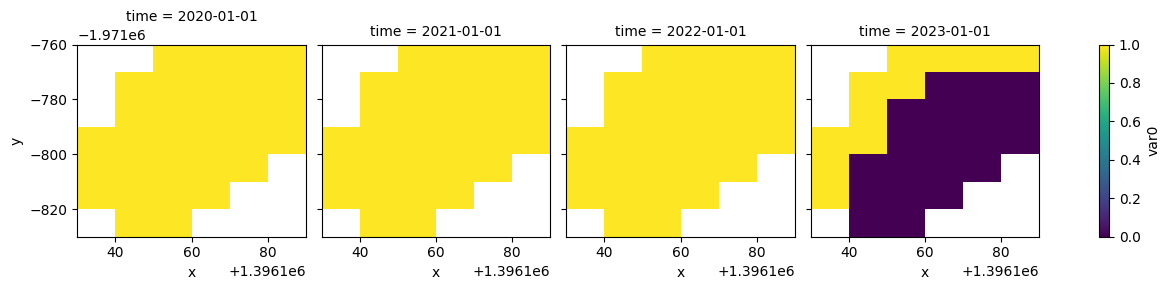

In [27]:
import numpy as np

ds_for.astype(np.float32).rio.clip([gdf.geometry.iloc[0]]).plot(col="time")

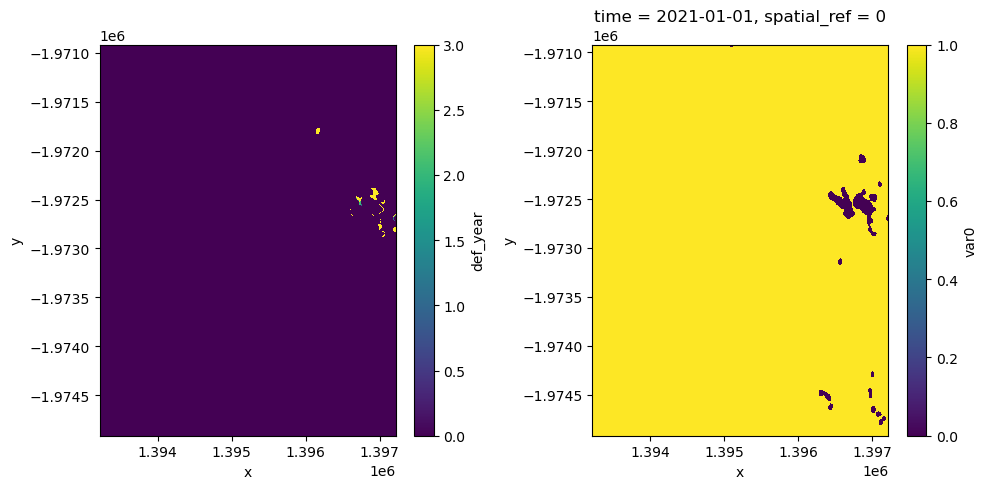

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

da = xr.open_dataset("defor_200_200.nc")
da = da.def_year
da.where(da<255, 0).plot(ax=axes[0])


ds_for.isel(time=1).plot(ax=axes[1])

plt.tight_layout()
plt.show()

In [13]:
gdf.head()

,def_year,geometry
1,3.0,"POLYGON ((1396154.806 -1971764.493, 1396194.80..."
4,3.0,"POLYGON ((1396884.806 -1972384.493, 1396944.80..."
5,3.0,"POLYGON ((1396684.806 -1972464.493, 1396684.80..."
6,2.0,"POLYGON ((1396684.806 -1972484.493, 1396684.80..."
7,2.0,"POLYGON ((1396704.806 -1972504.493, 1396704.80..."


In [7]:
ds_for.time

<xarray.DataArray 'time' (time: 4)>
array(['2020-01-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01 2021-01-01 ... 2023-01-01
    spatial_ref  int64 0

### Invetigate forest changes compared to deforestation

In [14]:
gdf[:10]

,def_year,geometry
1,3.0,"POLYGON ((1396154.806 -1971764.493, 1396194.80..."
4,3.0,"POLYGON ((1396884.806 -1972384.493, 1396944.80..."
5,3.0,"POLYGON ((1396684.806 -1972464.493, 1396684.80..."
6,2.0,"POLYGON ((1396684.806 -1972484.493, 1396684.80..."
7,2.0,"POLYGON ((1396704.806 -1972504.493, 1396704.80..."
8,2.0,"POLYGON ((1396714.806 -1972514.493, 1396714.80..."
9,2.0,"POLYGON ((1396734.806 -1972514.493, 1396744.80..."
10,3.0,"POLYGON ((1397064.806 -1972484.493, 1397074.80..."
11,1.0,"POLYGON ((1396744.806 -1972544.493, 1396744.80..."
12,3.0,"POLYGON ((1396994.806 -1972544.493, 1396994.80..."


In [15]:
# deforested 23:
print(gdf.iloc[0].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[0]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

# forest dropped in 2023 => correct


3.0

year 2020 forest mean: 1.0
year 2021 forest mean: 1.0
year 2022 forest mean: 1.0
year 2023 forest mean: 0.5238095238095238


In [27]:
# deforested 23:
print(gdf.iloc[4].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[4]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)


3.0

year 2020 forest mean: 0.9523809523809523
year 2021 forest mean: 0.9523809523809523
year 2022 forest mean: 0.9285714285714286
year 2023 forest mean: 0.6428571428571429


In [30]:
# deforested 22:
print(gdf.iloc[5].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[5]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

2.0

year 2020 forest mean: 1.0
year 2021 forest mean: 1.0
year 2022 forest mean: 0.0
year 2023 forest mean: 0.0


In [32]:
# deforested 21:
print(gdf.iloc[9].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[9]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

# incorrect change. should be 2022

1.0

year 2020 forest mean: 1.0
year 2021 forest mean: 1.0
year 2022 forest mean: 0.0
year 2023 forest mean: 0.0


In [33]:
# deforested 23:
print(gdf.iloc[11].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[11]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

3.0

year 2020 forest mean: 1.0
year 2021 forest mean: 1.0
year 2022 forest mean: 1.0
year 2023 forest mean: 0.5


In [40]:
# deforested 23:
print(gdf.iloc[14].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[14]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

3.0

year 2020 forest mean: 0.3333333333333333
year 2021 forest mean: 0.3333333333333333
year 2022 forest mean: 0.3333333333333333
year 2023 forest mean: 0.0


In [43]:
# deforested 23:
print(gdf.iloc[27].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[27]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

# incorrect change. should be 0 i.e. forested

1.0

year 2020 forest mean: 1.0
year 2021 forest mean: 1.0
year 2022 forest mean: 1.0
year 2023 forest mean: 1.0


In [34]:
# deforested 21:
print(gdf.iloc[30].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[30]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

1.0

year 2020 forest mean: 1.0
year 2021 forest mean: 0.0
year 2022 forest mean: 0.0
year 2023 forest mean: 0.0


In [38]:
# deforested 23:
print(gdf.iloc[37].def_year)
print()
years = [2020, 2021, 2022, 2023]
for t in range(0, 4):
    d = ds_for.isel(time=t).rio.clip([gdf.geometry.iloc[37]]).mean(dim=('x','y')).values
    print('year', years[t], 'forest mean:', d)

3.0

year 2020 forest mean: 0.625
year 2021 forest mean: 0.625
year 2022 forest mean: 0.625
year 2023 forest mean: 0.5


/home/muye/anaconda3/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


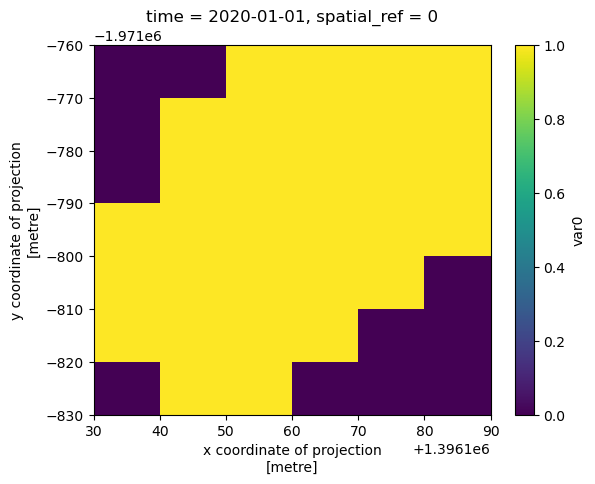

In [16]:
from geocube.vector import vectorize
da = xr.open_dataset("defor_200_200.nc").def_year
gdf = vectorize(da)
gdf = gdf[gdf["def_year"] != 255]
gdf = gdf[gdf["def_year"] != 0]
ds_for.isel(time=-1).rio.clip([gdf.geometry.iloc[0]]).plot()